### Import Dependencies

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
import random

seed = 1
random.seed(seed)
torch.manual_seed(seed)

### Constant Variables

In [4]:
DATASET_PATH = './knee-osteoarthritis_2'

In [5]:
TRAIN_PATH = f'{DATASET_PATH}/train'
VAL_PATH = f'{DATASET_PATH}/val'
TEST_PATH = f'{DATASET_PATH}/test'

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [7]:
classes = range(4)

### Dataset 

In [8]:
from src.dataset.augmented_dataset import get_KneeOsteoarthritis_Edges, KneeOsteoarthritis_Edges

transform_toTensor = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform_toTensor)
val_dataset = torchvision.datasets.ImageFolder(VAL_PATH, transform_toTensor)
test_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform_toTensor)

dataset_all = torch.utils.data.ConcatDataset([train_dataset, val_dataset, test_dataset])

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_all, [0.7, 0.1, 0.2])

train_dataset = KneeOsteoarthritis_Edges(train_dataset)
val_dataset = KneeOsteoarthritis_Edges(val_dataset)
test_dataset = KneeOsteoarthritis_Edges(test_dataset)

In [9]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

4736 676 1353


### Dataset Visualization

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def unnorm_img(x):
  return (x-np.min(x))/(np.max(x)-np.min(x))

# function to show some images from dataset
def plot_dataset(dataset, input_idx=0):
  rows, cols = 4, 4
  examples = {i: [] for i in range(len(classes))}

  for x, i in dataset:
    if all([len(ex) == rows for ex in examples.values()]):
      break
    if len(examples[i]) < rows:
      examples[i].append(x)

  fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
  
  if input_idx == 0:
    fig.suptitle('Original images', fontsize=16)
  elif input_idx == 1:
    fig.suptitle('Augmented images - focussed on vertical edge detection', fontsize=16)
  
  for i, label in enumerate(examples.keys()):
    
    class_examples = examples[label]

    for j, ex in enumerate(class_examples):
      img_clear = ex[input_idx]
      
      np_img_clear = img_clear.numpy()
      np_img_clear = unnorm_img(np_img_clear)
    
      ax = axes[i, j]
      ax.imshow(np.transpose(np_img_clear, (1, 2, 0)), cmap='gray')
      ax.set_title(f"{label}", fontsize=12)
      ax.axis('off')

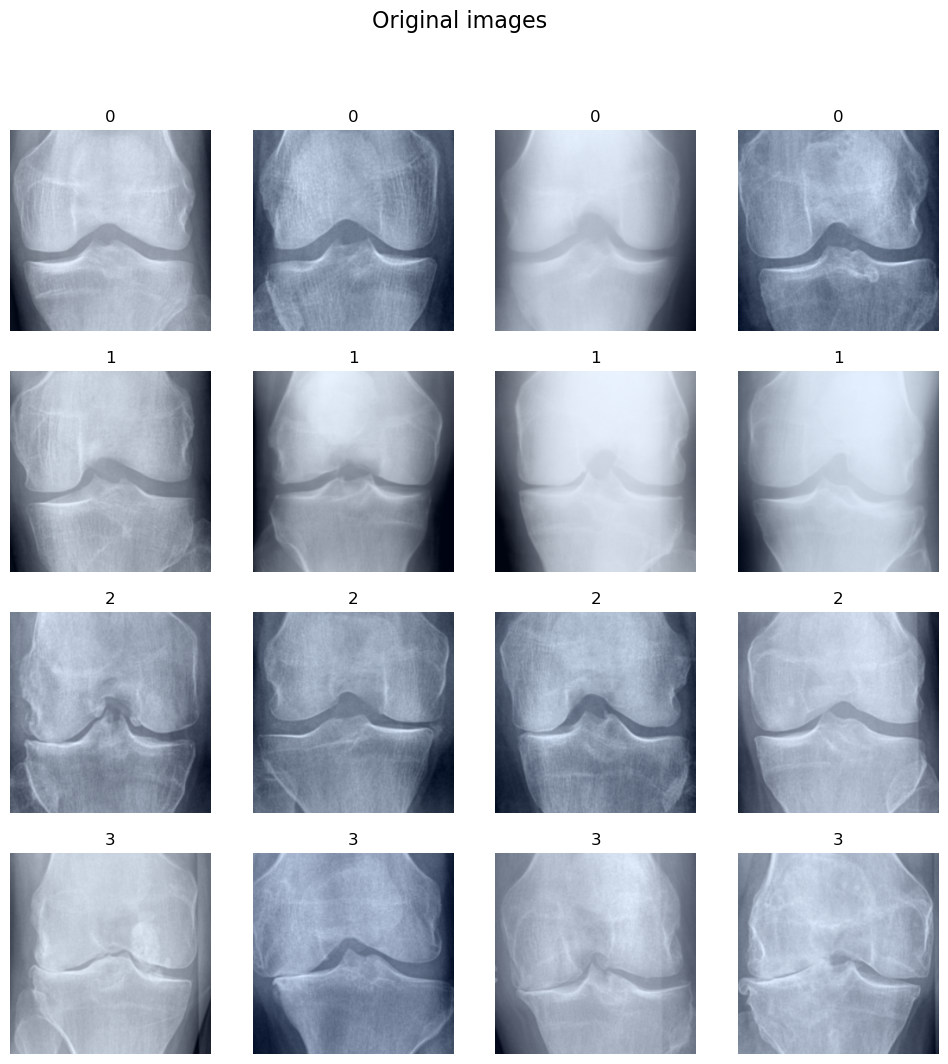

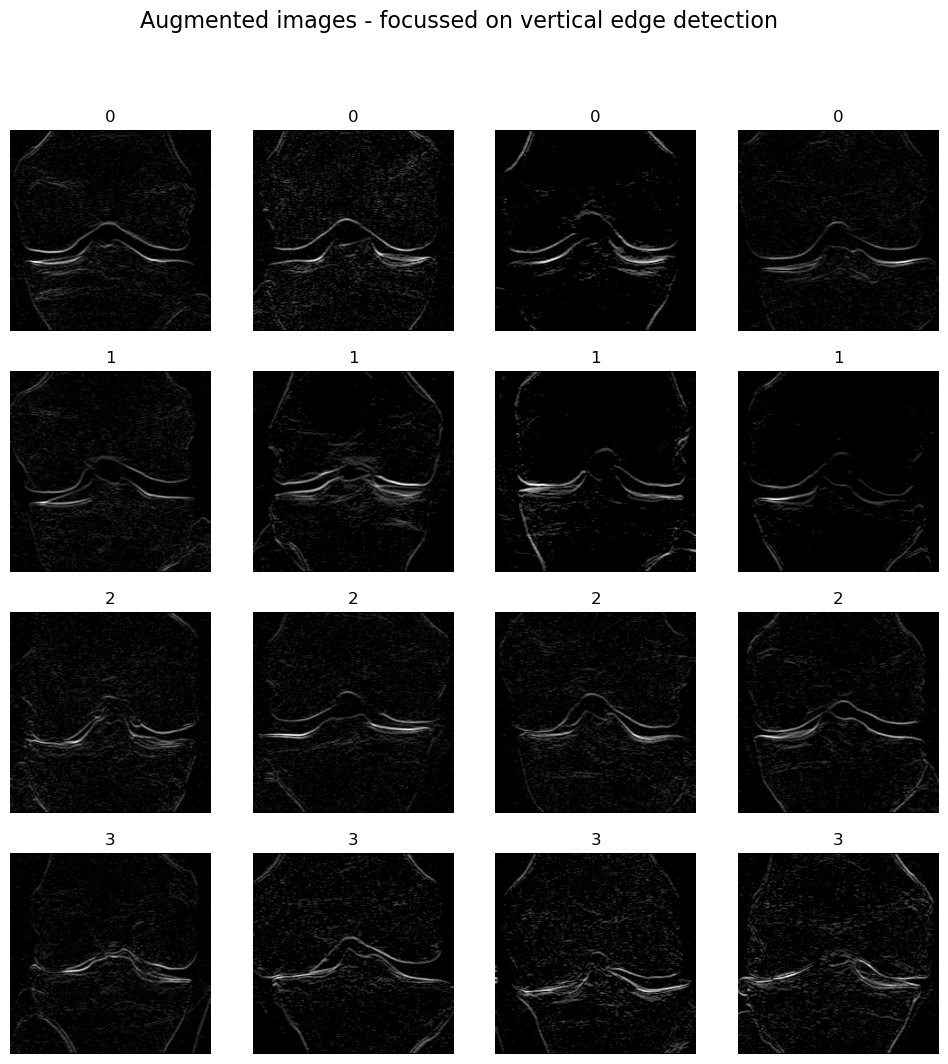

In [11]:
plot_dataset(train_dataset, 0)
plot_dataset(train_dataset, 1)

### Data Loader

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 512

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Model

In [11]:
class IntermediarySpaceModel(nn.Module):
    def __init__(self, train_device, num_classes: int = 5, dropout: float = 0.5) -> None:
        super().__init__()
        
        # Size of layer block
        S = 28
        self.train_device = train_device
        
        # Images
        self.imagesClassifier = nn.Sequential(
            nn.Conv2d(3, S*2, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.2),
            nn.Conv2d(S*2, S*2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.4),
            nn.Conv2d(S*2, S*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout*0.6),
            nn.Conv2d(S*2, S, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            nn.Dropout(p=dropout*0.8),
            nn.Linear(S * 7 * 7, S*2),
        )

        self.edgesClassifier = nn.Sequential(
            nn.Conv2d(1, S*2, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.4),
            nn.Conv2d(S*2, S*2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.6),
            nn.Conv2d(S*2, S, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            nn.Dropout(p=dropout*0.8),
            nn.Linear(S * 6 * 6, S*2),
        )
        
        self.outputCombiner = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S*4, S*3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S*3, S),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S, num_classes),
        )
        
    def forward(self, data: tuple) -> torch.Tensor:
        
        images, edges = data
        
        images = images.to(self.train_device)
        edges = edges.to(self.train_device)
        
        # Images
        images = self.imagesClassifier(images)
        
        # Edges
        edges = self.edgesClassifier(edges)
        
        # Combining outputs
        concated = torch.cat((images, edges), 1)
        res = self.outputCombiner(concated)
        
        return res

In [12]:
model = IntermediarySpaceModel(device, 4, 0.5)
model = model.to(device)

In [13]:
# print(sum(p.numel() for p in net.classifier.parameters()) ,sum(p.numel() for p in net.edgesClassifier.parameters()) )
print(sum(p.numel() for p in model.parameters()))

trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
print(sum(p.numel() for p in trainable_parameters))

386068
386068


### Configuring Trainer

#### Criterion & Optimizer

In [14]:
import torch.optim as optim
from src.other import get_classes_frequencies

class_weights = get_classes_frequencies(train_dataset)
weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
print(class_weights, weights_tensor)

criterion = nn.CrossEntropyLoss(weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

{0: 2297, 2: 769, 1: 1495, 3: 175} tensor([2297.,  769., 1495.,  175.], device='cuda:0')


#### Decaying Learning Rate Scheduler

In [15]:
decayRate100 = 0.5
decayRate1 = decayRate100**(1/100)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate1)

print(decayRate1)

0.9930924954370359


#### Tensorboard Logger

In [16]:
from torch.utils.tensorboard import SummaryWriter

logger = SummaryWriter(log_dir=f"logs/hyperparameters_tunned/3")

### Trainer

In [17]:
from src.training import Trainer

trainer = Trainer(
  model=model,
  classes=classes,
  train_loader=train_loader,
  val_loader=val_loader,
  criterion=criterion,
  optimizer=optimizer,
  device=device,
  lr_scheduler=lr_scheduler,
  reg_type="L2",
  reg_lambda=0.027,
  tensorboard_logger=logger
)

#### Model Results Visualization

In [18]:
from src.other import get_confusion_matrix_display

def visualize_all(model, epoch):
    tAccuracy, tLoss, tReport, tCm = trainer.evaluate(trainer.train_loader)
    vAccuracy, vLoss, vReport, vCm = trainer.evaluate(trainer.val_loader)
    print(f"training accuracy: {tAccuracy}, training loss: {tLoss}, validation accuracy: {vAccuracy}, validation loss: {vLoss}")
    print(f"Training report: {tReport}")
    print(f"Validation report: {vReport}")
    
    get_confusion_matrix_display(tCm, classes, "Training", epoch)
    get_confusion_matrix_display(vCm, classes, "Validation", epoch)

### Training Model

In [19]:
trainer.train_many(100, True)

Epoch 1: Training: accuracy: 31.440%, loss: 6.189; Validation: accuracy: 48.225%, loss: 1.304, lr: 0.00010
Epoch 2: Training: accuracy: 48.374%, loss: 5.692; Validation: accuracy: 49.260%, loss: 0.916, lr: 0.00010
Epoch 3: Training: accuracy: 48.501%, loss: 5.450; Validation: accuracy: 49.260%, loss: 0.957, lr: 0.00010
Epoch 4: Training: accuracy: 48.501%, loss: 5.238; Validation: accuracy: 49.260%, loss: 0.815, lr: 0.00010
Epoch 5: Training: accuracy: 48.501%, loss: 5.113; Validation: accuracy: 49.260%, loss: 0.887, lr: 0.00010
Epoch 6: Training: accuracy: 48.501%, loss: 4.831; Validation: accuracy: 49.260%, loss: 0.782, lr: 0.00010
Epoch 7: Training: accuracy: 48.501%, loss: 4.635; Validation: accuracy: 49.260%, loss: 0.865, lr: 0.00010
Epoch 8: Training: accuracy: 48.501%, loss: 4.516; Validation: accuracy: 49.260%, loss: 0.903, lr: 0.00010
Epoch 9: Training: accuracy: 48.501%, loss: 4.332; Validation: accuracy: 49.260%, loss: 0.846, lr: 0.00009
Epoch 10: Training: accuracy: 48.501%

(76.30912162162163,
 tensor(1.3512, device='cuda:0', grad_fn=<AddBackward0>),
 69.8224852071006,
 tensor(0.4669, device='cuda:0'))

training accuracy: 77.04814189189189, training loss: 0.2793915867805481, validation accuracy: 69.8224852071006, validation loss: 0.46780842542648315
Training report:               precision    recall  f1-score   support

           0       0.79      0.99      0.88      2297
           1       0.86      0.47      0.60      1495
           2       0.66      0.88      0.75       769
           3        nan      0.00      0.00       175

    accuracy                           0.77      4736
   macro avg       0.77      0.58      0.56      4736
weighted avg       0.79      0.77      0.74      4736

Validation report:               precision    recall  f1-score   support

           0       0.73      0.91      0.81       333
           1       0.70      0.40      0.51       221
           2       0.61      0.82      0.70        97
           3        nan      0.00      0.00        25

    accuracy                           0.70       676
   macro avg       0.68      0.53      0.50       676


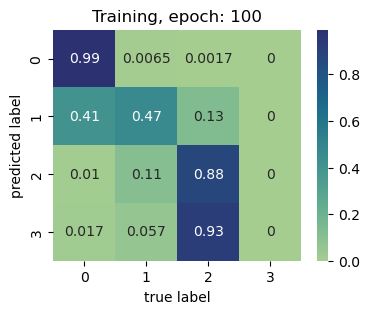

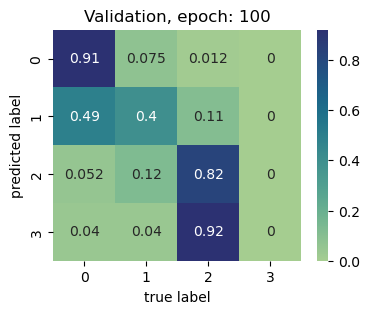

In [20]:
# test
visualize_all(model, trainer.epochCounter)

In [21]:
trainer.train_many(200, True)

Epoch 101: Training: accuracy: 76.119%, loss: 1.343; Validation: accuracy: 69.675%, loss: 0.475, lr: 0.00005
Epoch 102: Training: accuracy: 76.056%, loss: 1.363; Validation: accuracy: 69.379%, loss: 0.462, lr: 0.00005
Epoch 103: Training: accuracy: 76.161%, loss: 1.370; Validation: accuracy: 70.562%, loss: 0.534, lr: 0.00005
Epoch 104: Training: accuracy: 76.204%, loss: 1.296; Validation: accuracy: 69.527%, loss: 0.522, lr: 0.00005
Epoch 105: Training: accuracy: 77.217%, loss: 1.318; Validation: accuracy: 69.083%, loss: 0.494, lr: 0.00005
Epoch 106: Training: accuracy: 77.660%, loss: 1.356; Validation: accuracy: 68.787%, loss: 0.458, lr: 0.00005
Epoch 107: Training: accuracy: 76.921%, loss: 1.282; Validation: accuracy: 68.491%, loss: 0.551, lr: 0.00005
Epoch 108: Training: accuracy: 75.760%, loss: 1.350; Validation: accuracy: 68.343%, loss: 0.464, lr: 0.00005
Epoch 109: Training: accuracy: 76.225%, loss: 1.290; Validation: accuracy: 68.787%, loss: 0.459, lr: 0.00005
Epoch 110: Training

(91.32179054054055,
 tensor(0.7906, device='cuda:0', grad_fn=<AddBackward0>),
 72.18934911242603,
 tensor(0.5429, device='cuda:0'))

training accuracy: 91.23733108108108, training loss: 0.10483939945697784, validation accuracy: 72.18934911242603, validation loss: 0.6167060136795044
Training report:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      2297
           1       0.97      0.86      0.91      1495
           2       0.74      0.96      0.83       769
           3        nan      0.00      0.00       175

    accuracy                           0.91      4736
   macro avg       0.89      0.70      0.68      4736
weighted avg       0.92      0.91      0.90      4736

Validation report:               precision    recall  f1-score   support

           0       0.78      0.85      0.81       333
           1       0.66      0.57      0.61       221
           2       0.65      0.84      0.73        97
           3        nan      0.00      0.00        25

    accuracy                           0.72       676
   macro avg       0.70      0.56      0.54       676

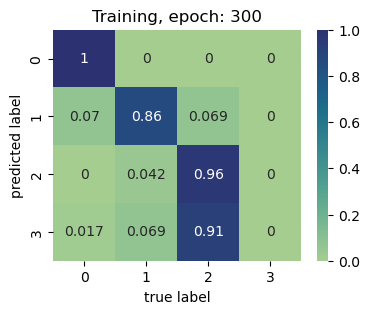

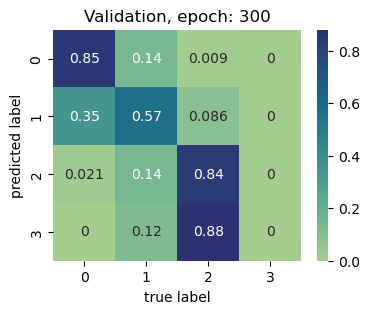

In [22]:
# test
visualize_all(model, trainer.epochCounter)

In [23]:
trainer.train_many(200, True)

Epoch 301: Training: accuracy: 91.111%, loss: 0.786; Validation: accuracy: 71.746%, loss: 0.448, lr: 0.00001
Epoch 302: Training: accuracy: 91.575%, loss: 0.789; Validation: accuracy: 71.893%, loss: 0.515, lr: 0.00001
Epoch 303: Training: accuracy: 90.963%, loss: 0.787; Validation: accuracy: 71.450%, loss: 0.618, lr: 0.00001
Epoch 304: Training: accuracy: 91.322%, loss: 0.765; Validation: accuracy: 72.041%, loss: 0.613, lr: 0.00001
Epoch 305: Training: accuracy: 91.660%, loss: 0.774; Validation: accuracy: 72.041%, loss: 0.650, lr: 0.00001
Epoch 306: Training: accuracy: 91.406%, loss: 0.807; Validation: accuracy: 72.041%, loss: 0.676, lr: 0.00001
Epoch 307: Training: accuracy: 91.491%, loss: 0.751; Validation: accuracy: 71.746%, loss: 0.595, lr: 0.00001
Epoch 308: Training: accuracy: 91.512%, loss: 0.796; Validation: accuracy: 71.746%, loss: 0.529, lr: 0.00001
Epoch 309: Training: accuracy: 91.660%, loss: 0.760; Validation: accuracy: 71.746%, loss: 0.595, lr: 0.00001
Epoch 310: Training

(93.49662162162163,
 tensor(0.6667, device='cuda:0', grad_fn=<AddBackward0>),
 72.18934911242603,
 tensor(0.5979, device='cuda:0'))

training accuracy: 93.47550675675676, training loss: 0.1177801787853241, validation accuracy: 72.18934911242603, validation loss: 0.713375449180603
Training report:               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2297
           1       0.97      0.93      0.95      1495
           2       0.76      0.97      0.85       769
           3        nan      0.00      0.00       175

    accuracy                           0.93      4736
   macro avg       0.91      0.72      0.70      4736
weighted avg       0.94      0.93      0.92      4736

Validation report:               precision    recall  f1-score   support

           0       0.79      0.82      0.81       333
           1       0.64      0.61      0.62       221
           2       0.66      0.82      0.73        97
           3        nan      0.00      0.00        25

    accuracy                           0.72       676
   macro avg       0.70      0.56      0.54       676
w

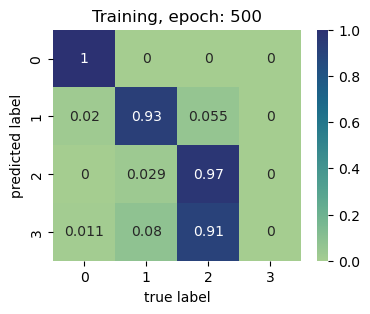

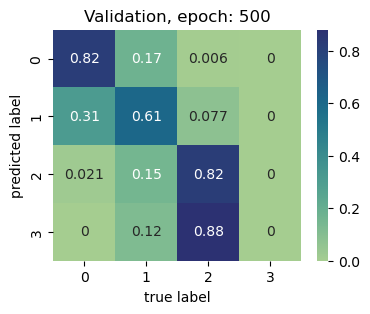

In [26]:
# test
visualize_all(model, trainer.epochCounter)

In [31]:
trainer.evaluate(test_loader)

(70.21433850702144,
 tensor(0.6512, device='cuda:0'),
 '              precision    recall  f1-score   support\n\n           0       0.77      0.85      0.81       623\n           1       0.64      0.56      0.60       459\n           2       0.62      0.74      0.68       220\n           3        nan      0.00      0.00        51\n\n    accuracy                           0.70      1353\n   macro avg       0.68      0.54      0.52      1353\nweighted avg       0.70      0.70      0.68      1353\n',
 array([[531,  87,   5,   0],
        [156, 256,  47,   0],
        [  4,  53, 163,   0],
        [  0,   5,  46,   0]]))

In [24]:
torch.save(model, "saved_models/model_saved.pt")

In [25]:
# model_2 = torch.load("saved_models/model_saved.pt", weights_only=False)